In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from keras.utils.np_utils import to_categorical  

from torchsummary import summary

from torch.optim import lr_scheduler

In [3]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data extraction and preprocessing

In [4]:
train = pd.read_csv('data/train.csv')


In [4]:
display(train.head())
train.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [5]:
X = np.array([[i for i in map(int, row)] for row in map(str.split, train['pixels'])])

In [51]:
X

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 74,  81,  87, ..., 188, 187, 187],
       [222, 227, 203, ..., 136, 136, 134],
       [195, 199, 205, ...,   6,  15,  38]])

In [8]:
X.shape

(28709, 2304)

In [6]:
y = train['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

# Data visualisation

In [10]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [11]:
def plot_images(X, y, classes=7, columns=5):
  _X = np.zeros((7 * 5, 2304))
  _y = []

  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + 5] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 15))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image.reshape((48, 48)), cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

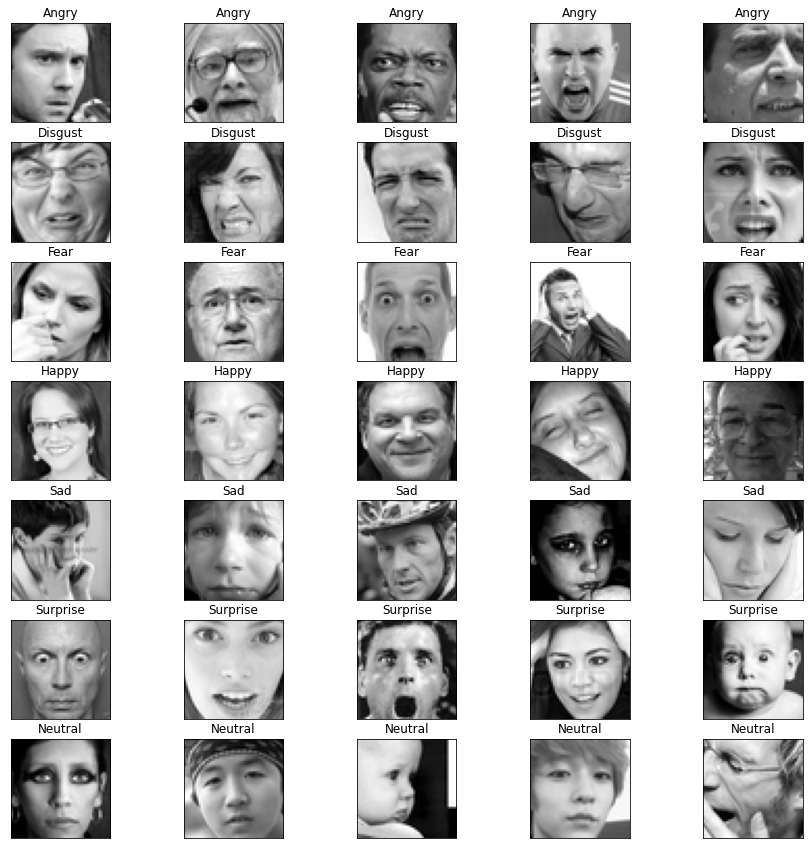

In [12]:
plot_images(X, y)

In [13]:
def drop_images(X, y, drop_count={3: 3000}):
  indices_to_delete = []
  
  for i in range(len(y)):
    if y[i] in drop_count.keys and drop_count[y[i]]:
      indices_to_delete.append(i)
      drop_count[y[i]] -= 1
  
  X = np.delete(X, indices_to_delete, axis=0)
  y = np.delete(y, indices_to_delete)

  return X, y


In [14]:
# X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
# X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

# Models

In [7]:
class Net(nn.Module):
  def __init__(self, backbone):
    super(Net, self).__init__()
    
    # last layer
    backbone.fc = nn.Linear(backbone.fc.in_features, 7)
    # print(backbone.__dict__)

    self.model = nn.Sequential(
        # first layer (mapping grayscale pictures to 3 channels)
        nn.Conv2d(1, 3, 1),
        backbone,
        # nn.Linear(28, 7),
        # nn.ReLU(7),
        nn.Softmax(dim=1)
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [32]:
# Training model
def train_model(model, criterion, optimizer, scheduler, train_loader,
                transform, epochs=1000):
    print('\n* Model training * ')

    count = 0
    iteration_list = []
    accuracy_list = []
    loss_list = np.array((epochs, len(train_loader))
    

    for epoch in range(epochs):
        print(f'\t* epoch #{epoch + 1}')
        for batch, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
        
            # outputs = model(transform(images.to(device)).unsqueeze(1))
            outputs = model(images.to(device).unsqueeze(1))

            loss = criterion(outputs, labels.to(device))
        
            loss.backward()
        
            optimizer.step()

            scheduler.step()

            print(f'\t\t batch: #{batch + 1}, loss: {loss}')
            loss_list[epoch, batch] = loss
        
            count += 1
        
            # # Predicitons
            # if count % 10 == 0:     
            #     # Predict test
            #     for images, labels in train_loader:
            #         # Forward
            #           model.eval()
            #           with torch.no_grad():
            #             outputs = model(transform(images.to(device)).unsqueeze(1))
            #           model.train()

            #         # Get prediction as maximum of probs
            #           predicted = torch.max(outputs.data, 1)[1]
                      
            #           labels = labels.to(device)
            #           break
                
            #     accuracy = metrics.accuracy_score(labels.nonzero()[:, 1], predicted)
            #     print('acc', accuracy)
            
            #     # store loss, accuracy and iteration
            #     loss_list.append(loss.data)
            #     accuracy_list.append(accuracy)
            #     iteration_list.append(count)
            
            # if count % 15 == 0:
            #     print(f"Iteration: {count}  Loss: {loss.data}  Accuracy: {int(accuracy * 100)}%")

                
    return loss_list

SyntaxError: ignored

In [9]:
# Testing model
def test_model(model, test_loader):
    print('\n* Model testing * ')
    predictions = []

    for i, (images, labels) in enumerate(test_loader): 
      print(f'\t* batch #{i + 1}')

      with torch.no_grad():  
        data = images.to(device).unsqueeze(1)
        outputs = model(data)

        predicted = torch.max(outputs.data, 1)[1]
        predictions.extend(map(int, predicted))

    return predictions

In [10]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

In [24]:
def run_pipeline(
    X,
    y,
    model=models.resnet18(pretrained=True), 
    batch_size=2048,
    error=nn.CrossEntropyLoss(), 
    lr=0.001,
    epochs=1,
    show_summary=False,
    random_state=42,
    step_size=5,
    gamma=1):

    # Data preperation
    X = X.reshape((X.shape[0], 48, 48))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    y_train_categorical = to_categorical(y_train, num_classes=7)
    y_test_categorical = to_categorical(y_test, num_classes=7)

    # Tensors
    featuresTrain = torch.from_numpy(X_train).float()
    targetsTrain = torch.from_numpy(y_train_categorical).float()

    featuresTest = torch.from_numpy(X_test).float()
    targetsTest = torch.from_numpy(y_test_categorical).float()

    # Loading data on gpu ( if exists )
    featuresTrain.to(device)
    targetsTrain.to(device)

    featuresTest.to(device)
    targetsTest.to(device)
    
    # TensorDataset's
    train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
    test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

    # Augmentation
    transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation((-45,45))
    ])

    # Data loader
    generator = torch.Generator()
    generator = torch.manual_seed(random_state)
    train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, 
                              generator=generator)
    test_loader = DataLoader(test, batch_size=batch_size,
                              shuffle=False)

    # Model
    net = Net(backbone=model).to(device)
    
    # Model summary
    if show_summary:
        summary(net, (1, 48, 48))

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    net = train_model(net, error, optimizer, scheduler, train_loader, 
                      transform, epochs)

    predictions = test_model(net, test_loader)

    print('Accuracy: ', metrics.accuracy_score(y_test, predictions))
    plot_confusin_matrix(y_test, predictions)


* Model training * 
	* epoch #1
		 batch: #1, loss: 1.9503581523895264
		 batch: #2, loss: 1.8909833431243896
		 batch: #3, loss: 1.8464481830596924
		 batch: #4, loss: 1.78334641456604
		 batch: #5, loss: 1.751216173171997
		 batch: #6, loss: 1.7418456077575684
		 batch: #7, loss: 1.7191176414489746
		 batch: #8, loss: 1.6934083700180054
		 batch: #9, loss: 1.6876559257507324
		 batch: #10, loss: 1.6803919076919556
		 batch: #11, loss: 1.690509557723999
		 batch: #12, loss: 1.6905702352523804
	* epoch #2
		 batch: #1, loss: 1.6356068849563599
		 batch: #2, loss: 1.6421213150024414
		 batch: #3, loss: 1.626207947731018
		 batch: #4, loss: 1.6251709461212158
		 batch: #5, loss: 1.6303513050079346
		 batch: #6, loss: 1.5970492362976074
		 batch: #7, loss: 1.607734203338623
		 batch: #8, loss: 1.6143877506256104
		 batch: #9, loss: 1.5983574390411377
		 batch: #10, loss: 1.6168155670166016
		 batch: #11, loss: 1.6065330505371094
		 batch: #12, loss: 1.5646668672561646
	* epoch #3
		 batc

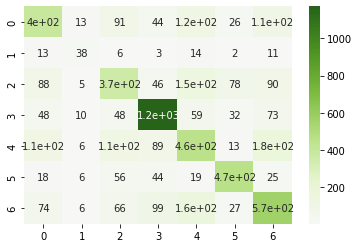

In [31]:
run_pipeline(X, y, model=models.resnet18(pretrained=True), show_summary=False,
             epochs=100, batch_size=2048, lr=0.0005, step_size=5, gamma=1)


* Model training * 
	* epoch #1
		 batch: #1, loss: 1.9503581999743211
		 batch: #2, loss: 1.8909972645249
		 batch: #3, loss: 1.8465642766109773
		 batch: #4, loss: 1.7831769329641156
		 batch: #5, loss: 1.7508446638583255
		 batch: #6, loss: 1.7416125602742238
		 batch: #7, loss: 1.7190037670484875
		 batch: #8, loss: 1.6938505506912762
		 batch: #9, loss: 1.688555617185402
		 batch: #10, loss: 1.6820540082243005
		 batch: #11, loss: 1.6907342040310875
		 batch: #12, loss: 1.6893143209400305
	* epoch #2
		 batch: #1, loss: 1.6350725059398556
		 batch: #2, loss: 1.6423360157613192
		 batch: #3, loss: 1.6250300190384128
		 batch: #4, loss: 1.6247937310928466
		 batch: #5, loss: 1.627455010297516
		 batch: #6, loss: 1.593005016236814
		 batch: #7, loss: 1.6125017952251328
		 batch: #8, loss: 1.619768857024097
		 batch: #9, loss: 1.5971759063242643
		 batch: #10, loss: 1.6154462337570037
		 batch: #11, loss: 1.601505733637685
		 batch: #12, loss: 1.5642458151279661
	* epoch #3
		 batch:

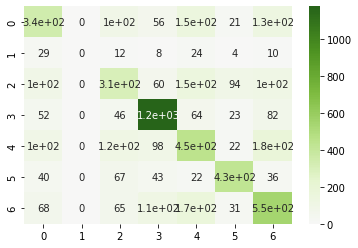

In [72]:
run_pipeline(X, y, model=models.resnet18(pretrained=True), epochs=5, batch_size=2048, lr=0.0005, gamma=1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]


* Model training * 
	* epoch #1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


		 batch: #1, loss: 1.9490677068561668
		 batch: #2, loss: 1.9274034751035143
		 batch: #3, loss: 1.9095237951491635
		 batch: #4, loss: 1.8862918200469891
		 batch: #5, loss: 1.8579073536921658
		 batch: #6, loss: 1.8396020919871363
		 batch: #7, loss: 1.8098900918586722
		 batch: #8, loss: 1.7990146276287273
		 batch: #9, loss: 1.7691936553759335
		 batch: #10, loss: 1.751561706472124
		 batch: #11, loss: 1.7402187450676028
		 batch: #12, loss: 1.729640579259715
	* epoch #2
		 batch: #1, loss: 1.6955990517395136
		 batch: #2, loss: 1.7001949287863511
		 batch: #3, loss: 1.6924243956457707
		 batch: #4, loss: 1.6914330000631028
		 batch: #5, loss: 1.6684422420618152
		 batch: #6, loss: 1.6774076763491892
		 batch: #7, loss: 1.6654109256191787
		 batch: #8, loss: 1.6804363370222024
		 batch: #9, loss: 1.6652435425298378
		 batch: #10, loss: 1.6553416958930343
		 batch: #11, loss: 1.6737374506816947
		 batch: #12, loss: 1.63832744327789
	* epoch #3
		 batch: #1, loss: 1.6117117462948816

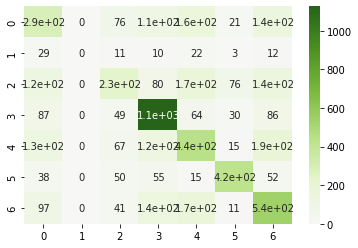

In [73]:
run_pipeline(X, y, model=models.googlenet(pretrained=True), epochs=5, batch_size=2048, lr=0.0005, gamma=1)

# Some thoughts about project improvements.

Firstly, we need to specify much larger epoch rate (in this work it's not quite enough, due to the power and time limitations).<br>
Inception model is not used because image size is too small for that model (MaxPool2d layers reduce our image size too much).<br>
Considered models have their own traits & features, but for our task their behaviour tends to be almost the same. <br><br>
To try to improve model efficiency we can add some custom layers above our backbone model.<br><br>
In out dataset we've got a class imbalance:<br>
7215 images for emotion "happy" (class 3)<br>
436 images for emotion "disgust" (class 1)<br>
~3000-5000 for other emotions<br><br>
As a result, accuracy is not a good option as a main metric (as we see our badly trained models mostly ignores classes apart from "happy", and we can assume that trained model could neglect of taking into accout emotion "disgust" and still have a good accuracy score).
To overcome this problem we can use recall score with micro-averaging, or other metrics such as F1-score, ROC/ROC AUC etc.<br><br>
To overcome imbalance we can also reduce the biggest classes, or use on the smallest classes such technics as augmentation more, or use that two methods simultaneously. <br><br>
Also, it's nice to have validations during training, and afterwards we can use that information for plot relationship between epochs and training & validation scores. (I decided not to use it and commented it in order not to raise model complexity)

# Conlusions
During this project, i have got better understanding of Tensorflow, Keras (initially used it for current project and coded a simple model via it) and PyTorch (switched to PyTorch afterwards). In the process of completing study, I get acquainted with Google Colaboratory, different neural networks, aspecially with classifiers with backbone architecture such as ResNet, EfficientNet, Inception & GoggleNet. Learned terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.